## Курсовой проект для курса "Python для Data Science" - Дмитрий Жегалов 

### Задание для курсового проекта

**Задание:**
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

**Целевая переменная:**
Price

**Основная метрика:**
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Вспомогательная метрика:**
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)


`Id` - идентификационный номер квартиры

`DistrictId` - идентификационный номер района

`Rooms` - количество комнат

`Square` - площадь

`LifeSquare` - жилая площадь

`KitchenSquare` - площадь кухни

`Floor` - этаж

`HouseFloor` - количество этажей в доме

`HouseYear` - год постройки дома

`Ecology_1`, `Ecology_2`, `Ecology_3` - экологические показатели местности

`Social_1`, `Social_2`, `Social_3` - социальные показатели местности

`Healthcare_1`, `Helthcare_2` - показатели местности, связанные с охраной здоровья

`Shops_1`, `Shops_2` - показатели, связанные с наличием магазинов, торговых центров

`Price` - цена квартиры


**Импорт библиотек**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.metrics import accuracy_score
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Функции** 

In [3]:
def evaluate_preds(true_values_val, pred_values_val, true_values_tr, pred_values_tr, name):
    print("R2:\t" + str(round(r2(true_values_val, pred_values_val), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values_val, pred_values_val), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values_val, pred_values_val), 3)))
    
    plt.figure(figsize=(6,6))
    
    plt.scatter(pred_values_tr, true_values_tr, c = "blue", marker = "s", label = "Training data")
    plt.scatter(pred_values_val, true_values_val, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title(name)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.show()

**Загрузка данных**

In [4]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**Обзор данных**

In [5]:
df.shape

(10000, 20)

In [6]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [7]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Обработка данных

**Категориальные признаки**

In [8]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [9]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [10]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

*Каждая из номинативных переменных фактически содержит бинарные данные - при обработке можно предствить в виде (0 и 1):*

In [11]:
maping = {
    "A": 1,
    "B": 0,
}

df['Ecology_2'] = df['Ecology_2'].map(maping)
df['Ecology_3'] = df['Ecology_3'].map(maping)
df['Shops_2'] = df['Shops_2'].map(maping)

In [12]:
df['Id'] = df['Id'].astype(str)
df['DistrictId'] = df['DistrictId'].astype(str)

In [13]:
df['DistrictId'].nunique()

205

*Наблюдается лишь 205 уникальных значений для признака `DistrictId`. Каждому из наблюдению квартиры можно сопоставить хараткеризующие признаки района нахождения квартиры*

In [14]:
pivot_district = df.groupby('DistrictId')

In [15]:
pivot_district.agg({"Price": "max", "Id": "count"}).sort_values('Price').head(5)

,Price,Id
DistrictId,,
209,140048.802277,1
158,170893.643522,2
71,199321.457917,7
205,220501.566180,1
192,227143.120986,5


**Количественные признаки**

**Square**

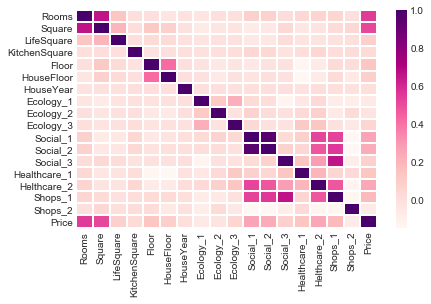

In [16]:
corr_matrix = df.drop(df.select_dtypes(include='object'), axis=1).corr()
sns.heatmap(corr_matrix, linewidths=1, xticklabels=True, yticklabels=True, cmap="RdPu")

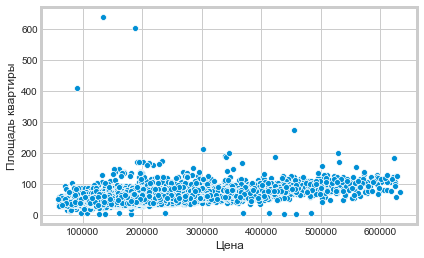

In [17]:
sns.scatterplot(df['Price'], df['Square'])


plt.xlabel('Цена')
plt.ylabel('Площадь квартиры')

plt.show()

*На распределении наблюдаются аномальные выбросы - так как при очень большой площади наблюдается крайне маленькая стоимость. Вероятно показтели площади указаны с ошибкой в разрядности. Для целей дальнейшего анализа величину площади разделим на 10 по данным наблюдениям.*

In [18]:
df.loc[(df['Price'] < 200000) & (df['Square'] > 400), ['Square', 'LifeSquare', 'KitchenSquare']] = df.loc[(df['Price'] < 200000) & (df['Square'] > 400), ['Square', 'LifeSquare', 'KitchenSquare']] / 10

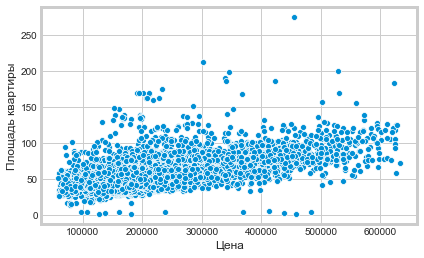

In [19]:
sns.scatterplot(df['Price'], df['Square'])


plt.xlabel('Цена')
plt.ylabel('Площадь квартиры')

plt.show()

In [20]:
df = df.loc[(df['Square'] > 15)]

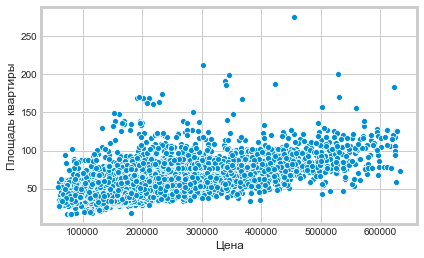

In [21]:
sns.scatterplot(df['Price'], df['Square'])


plt.xlabel('Цена')
plt.ylabel('Площадь квартиры')

plt.show()

**Rooms**

In [22]:
df['Rooms'].value_counts()

2.0     3879
1.0     3697
3.0     2232
4.0      150
5.0       18
0.0        7
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Для наблюдений, где признак:
* `Rooms = 0`; или
* `Rooms >= 6`
обучим модель для определения количсетва комнат (на данных о количестве комнат для наблюдений без аномалий).

**Создание классификатора количества комнат по площади квартиры**

In [23]:
rooms_square = df[['Rooms', 'Square']]
rooms_square.drop(rooms_square[rooms_square['Rooms'] >= 6].index, inplace=True)
rooms_square.drop(rooms_square[rooms_square['Rooms'] == 0].index, inplace=True)

In [24]:
rooms_square['Rooms'].value_counts()

2.0    3879
1.0    3697
3.0    2232
4.0     150
5.0      18
Name: Rooms, dtype: int64

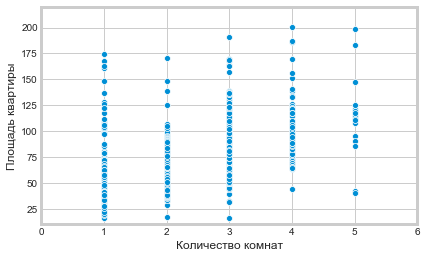

In [25]:
rooms_square = np.array(rooms_square)
sns.scatterplot(rooms_square[:, 0], rooms_square[:, 1])
plt.axis([0, 6, 10, 220])

plt.xlabel('Количество комнат')
plt.ylabel('Площадь квартиры')

plt.show()

*Наблюдаем ожидаемую закономерность - малометражные квартиры концентрируются в 1-ых квартирах. С увеличением метража - увеличвается количества комнат.*

Применим метод ближайших соседей (KNN) и Дерево решений для решения задачи классификации - определения количества комнат по величине метража квартиры. Для этого, сперва сравним оба метода и выберем наиболее предпочтительный.

***DecisionTreeClassifier***

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(rooms_square[:, 1], rooms_square[:, 0], test_size=0.25, random_state=42)

X_train = X_train.reshape(-1,1)
X_valid = X_valid.reshape(-1,1)

In [27]:
max_depth_values = np.arange(2, 20)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(max_depth_values):
    tree = DecisionTreeClassifier(max_depth=value)
    
    tree.fit(X_train, y_train)
    
    y_pred = tree.predict(X_valid)
    y_pred_train = tree.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 4 == 2:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 4
	acc_valid = 0.7706495589414595
	acc_train = 0.7588879978615344

K = 8
	acc_valid = 0.7574178027265437
	acc_train = 0.7757284148623362

K = 12
	acc_valid = 0.7445870088211708
	acc_train = 0.8092755947607592

K = 16
	acc_valid = 0.7165196471531676
	acc_train = 0.8503074044373162



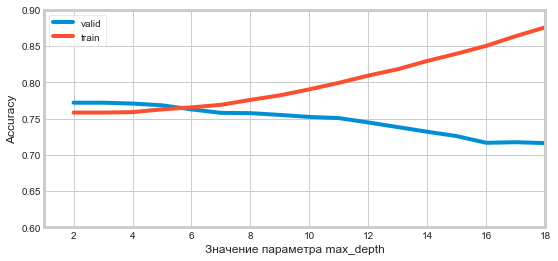

In [28]:
plt.rcParams['figure.figsize'] = 8, 4

plt.plot(max_depth_values, accuracy_on_valid, label="valid")
plt.plot(max_depth_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра max_depth')
plt.ylabel('Accuracy')

plt.legend()
plt.axis([1, 18, 0.6, 0.9])

plt.show()

***KNeighborsClassifier***

In [29]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [30]:
k_values = np.arange(1, 20)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(k_values):
    clf = KNeighborsClassifier(n_neighbors=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if (i % 2 == 0) and (i < 10):
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 1
	acc_valid = 0.653167602245389
	acc_train = 1.0

K = 3
	acc_valid = 0.694065757818765
	acc_train = 0.8250467789361133

K = 5
	acc_valid = 0.7141138732959101
	acc_train = 0.793237102379043

K = 7
	acc_valid = 0.7277465918203689
	acc_train = 0.7845495856722802

K = 9
	acc_valid = 0.7385725741780272
	acc_train = 0.7777332264100508



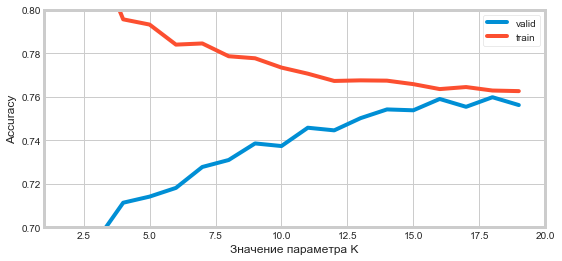

In [31]:
plt.plot(k_values, accuracy_on_valid, label="valid")
plt.plot(k_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра K')
plt.ylabel('Accuracy')

plt.axis([1, 20, 0.7, 0.8])
plt.legend()

plt.show()

***Финальная модель для предсказания `Rooms`***

*Сравнив оба метода - отдадим предпочтение методу Дерева решений с параметром глубины `max_depth = 3`. Данный метод дает схожую точность относительно KNN при `n_neighbors=20`* 

Обучим модель на полных данных (без выделения тестовой выборки) с помощью дерева решений с максимальной глубиной 4. Применим модель для предсказания количества комнат для кейсов, когда в обрабатываемом нами датасете:
* `Rooms = 0`; или
* `Rooms >= 6`

In [32]:
clf = DecisionTreeClassifier(max_depth=3)

X_train, y_train = rooms_square[:, 1].reshape(-1, 1), rooms_square[:, 0].reshape(-1, 1)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [33]:
y_pred = clf.predict(df.loc[(df['Rooms'] >= 6) | (df['Rooms'] == 0), 'Square'].values.reshape(-1, 1))
y_pred = pd.DataFrame(y_pred, columns = ['Rooms'])
y_pred.loc[y_pred['Rooms'].notnull(), 'Square'] = df.loc[(df['Rooms'] >= 6) | (df['Rooms'] == 0), 'Square'].values
y_pred

,Rooms,Square
0,2.0,59.056975
1,3.0,138.427694
2,1.0,42.006046
3,3.0,212.932361
4,2.0,59.414334
5,1.0,41.790881
6,2.0,49.483501
7,3.0,81.491446
8,1.0,38.697117
9,3.0,87.762616


In [34]:
df.loc[(df['Rooms'] >= 6) | (df['Rooms'] == 0), 'Rooms'] = np.array(y_pred['Rooms']).reshape(-1, 1)

**KitchenSquare**

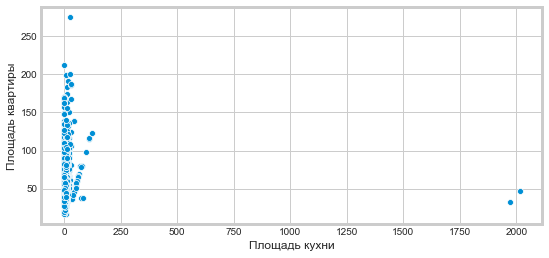

In [35]:
sns.scatterplot(df['KitchenSquare'], df['Square'])

plt.xlabel('Площадь кухни')
plt.ylabel('Площадь квартиры')

plt.show()

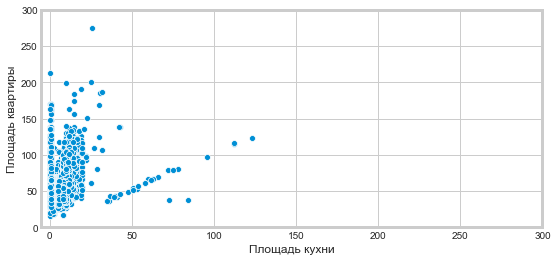

In [36]:
sns.scatterplot(df['KitchenSquare'], df['Square'])

plt.axis([-5, 300, 0, 300])
plt.xlabel('Площадь кухни')
plt.ylabel('Площадь квартиры')

plt.show()

Наблюдается 4 аномалии:

*для множества наблдений значение признака `KitchenSquare` = `0`;

*для множества наблдений значение признака `KitchenSquare` = `1`;

*для множества наблдений значение признака `KitchenSquare` близко к значению признака `Square` или более него;

*для нескольких наблдений значение признака `KitchenSquare` близко к 2000м2.

In [37]:
kitchen = df.loc[(df['KitchenSquare'] < df['Square'] * 0.89) & (df['KitchenSquare'] >= 3)]

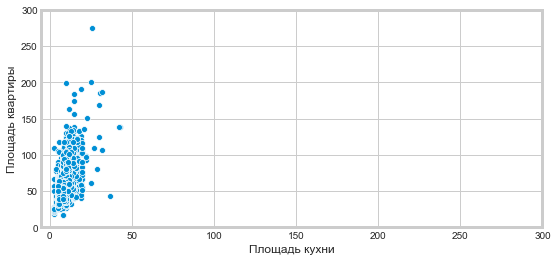

In [38]:
sns.scatterplot(kitchen['KitchenSquare'], kitchen['Square'])

plt.axis([-5, 300, 0, 300])
plt.xlabel('Площадь кухни')
plt.ylabel('Площадь квартиры')

plt.show()

Вычислим средний коэффициент отношения площади кухни к общей площади.

In [39]:
kitchen_coef = kitchen['KitchenSquare']/kitchen['Square']
kitchen_coef = kitchen_coef.mean()
kitchen_coef

0.15446045614436743

In [40]:
df.loc[(df['KitchenSquare'] >= df['Square'] * 0.89) | (df['KitchenSquare'] < 3), 'KitchenSquare'] = df.loc[(df['KitchenSquare'] >= df['Square'] * 0.89) | (df['KitchenSquare'] < 3), 'Square'] * kitchen_coef

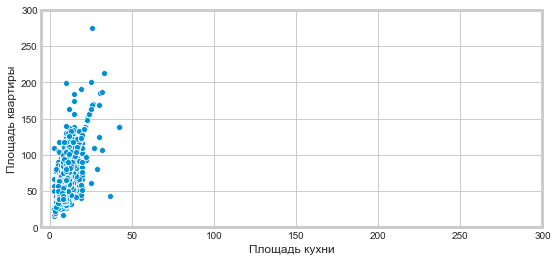

In [41]:
sns.scatterplot(df['KitchenSquare'], df['Square'])

plt.axis([-5, 300, 0, 300])
plt.xlabel('Площадь кухни')
plt.ylabel('Площадь квартиры')

plt.show()

**LifeSquare**

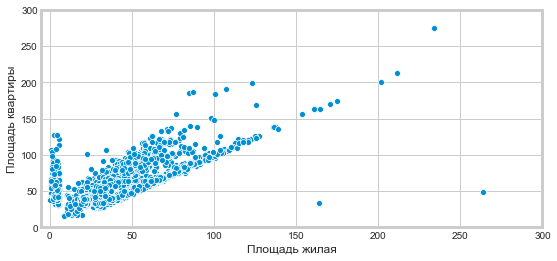

In [42]:
sns.scatterplot(df['LifeSquare'], df['Square'])

plt.axis([-5, 300, 0, 300])
plt.xlabel('Площадь жилая')
plt.ylabel('Площадь квартиры')

plt.show()

In [43]:
life = df.loc[(df['LifeSquare']>=df['Square']*0.4) & (df['LifeSquare']<=df['Square']*0.95)]

In [44]:
life_coef = life['LifeSquare']/life['Square']
life_coef = life_coef.mean()
life_coef

0.6147585821723002

In [45]:
df.loc[(df['LifeSquare']<df['Square']*0.4) | (df['LifeSquare']>df['Square']), 'LifeSquare'] = df.loc[(df['LifeSquare']<df['Square']*0.4) | (df['LifeSquare']>df['Square']), 'Square'] * life_coef

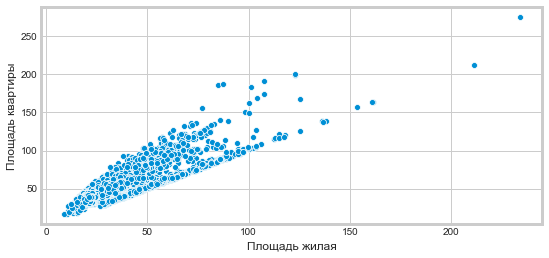

In [46]:
sns.scatterplot(df['LifeSquare'], df['Square'])


plt.xlabel('Площадь жилая')
plt.ylabel('Площадь квартиры')

plt.show()

In [47]:
life = life.loc[life['Square']>life['LifeSquare'] + life['KitchenSquare']]

In [48]:
diff = life.loc[life['Square'].notnull(), 'Square'] - life.loc[life['LifeSquare'].notnull(), 'LifeSquare'] - life.loc[life['KitchenSquare'].notnull(), 'KitchenSquare'] 

In [49]:
diff = diff.mean()

In [50]:
df.loc[(df['LifeSquare'].isnull()) | (df['Square'] < (df['LifeSquare'] + df['KitchenSquare'])), 'LifeSquare'] =\
df.loc[(df['LifeSquare'].isnull()) | (df['Square'] < (df['LifeSquare'] + df['KitchenSquare'])), 'Square'] -\
df.loc[(df['LifeSquare'].isnull()) | (df['Square'] < (df['LifeSquare'] + df['KitchenSquare'])), 'KitchenSquare'] - diff

**Floor и HouseFloor**

Проанализируем показтели `Floor` - этаж квартиры и `HouseFloor` - этажность дома:
* проверим наличе нулевых (не пустых, а со значением `0`) значений для данных признаков;
* проверим случаи когда этаж квартиры (`Floor`) больше этажности дома `HouseFloor`.

In [51]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

Выявлены наблюдения для которых `HouseFloor` (этажность дома) < `Floor` (этажности квартиры). Для исправления таких ситуаций примем этажность дома равной этажу квартиры

In [52]:
df.loc[df['HouseFloor'] < df['Floor'], 'HouseFloor'] = df.loc[df['HouseFloor'] < df['Floor'], 'Floor']

**HouseYear**

Далее проанализируем на наличие аномальных значений показтель `HouseYear` (год постройки)

In [53]:
df.nlargest(20, 'HouseYear').head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.000000,9,12.0,20052011,0.136330,0,0,30,6141,10,262.0,3,6,0,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.000000,4,9.0,4968,0.319809,0,0,25,4756,16,2857.0,5,8,0,243028.603096
585,15051,53,2.0,59.597891,44.869530,10.000000,3,24.0,2020,0.049637,0,0,34,7759,0,229.0,1,3,0,243114.222804
707,4345,62,1.0,49.275155,30.292324,7.611063,5,5.0,2020,0.072158,0,0,2,629,1,NaN,0,0,1,135353.885620
790,6845,169,3.0,87.371123,64.905206,12.000000,4,24.0,2020,0.178917,0,0,18,3594,4,192.0,1,5,0,295304.011974


Выявлены аномальные значения годов постройки `20052011` и `4968`. Также выявлены дома с годом постройки `2020`, что может свиедетельствовать что данные дома еще только строятся. Строящиеся жилье обладает своей спецификой ценообразования. Вероятно является целесообразным выделение дополнительного бинарного признака для строящегося жилья. При этом, не является известным дата сбора каждого из наблюдейний. Таким образом однозначано выделить строящиеся жилье не представляется возможным. Заменим аномальные значения на равно моде.

In [54]:
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = df['HouseYear'].mode().values

**Healthcare_1**

Признак `Healthcare_1` содержит слишком много пропусков. Удалим данный признак из данных для обучения.

In [55]:
df.drop(['Healthcare_1'], axis=1, inplace=True)

### Добавление  признаков для наблюдений

In [56]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'mean'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

In [57]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.930730,213160.076297
1,15053,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.450063,303643.563728
2,4765,53,2.0,44.947953,29.197612,6.942681,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.908524,259938.729121
3,5809,58,2.0,53.352981,30.887053,9.000000,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.227217,172368.882269
4,10783,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531644,155748.415754


### Обучение модели

In [58]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
            'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['MedPriceByDistrict']

target_name = 'Price'

In [59]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[features + new_feature_names]) 

In [60]:
df[features + new_feature_names]=pd.DataFrame(scl_f,columns=[features + new_feature_names])

In [61]:
X = df[features + new_feature_names]
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

***LinearRegression***

R2:	0.703
MAE:	32765.744
MSE:	2539340215.006


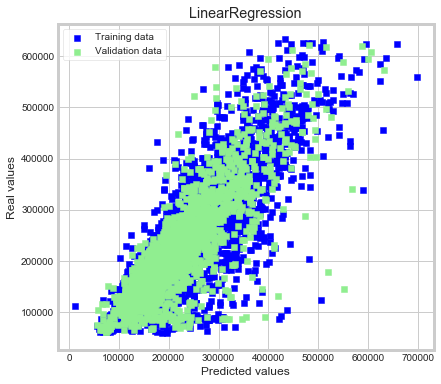

In [62]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_values_tr = lr.predict(X_train)
pred_values_val = lr.predict(X_test)
evaluate_preds(y_test, pred_values_val, y_train, pred_values_tr, 'LinearRegression')

***RandomForestRegressor***

R2:	0.719
MAE:	29352.59
MSE:	2402737881.188


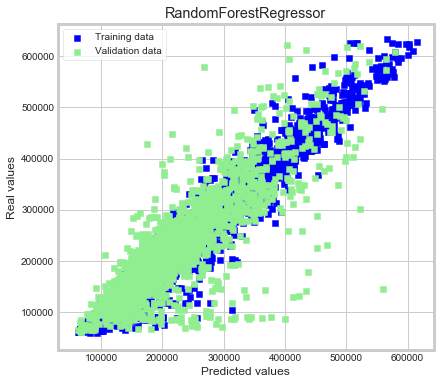

In [63]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_valid = rf_model.predict(X_test)
evaluate_preds(y_test, y_pred_rf_valid, y_train, y_pred_rf_train, 'RandomForestRegressor')

***GradientBoostingRegressor***

**gd.best_score_:** 

'max_depth': 7,

'min_samples_leaf': 3,

'min_samples_split': 10,
 
'n_estimators': 300}

R2:	0.769
MAE:	26044.903
MSE:	1977666875.069


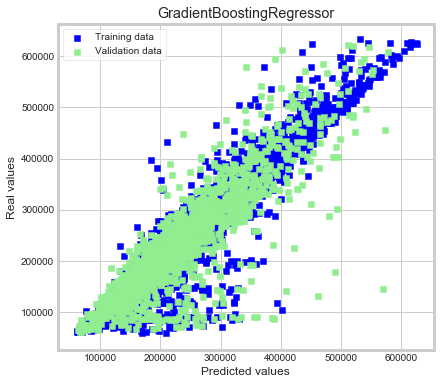

In [64]:
gbr = GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt', loss='huber', random_state = 5, 
                                max_depth = 7, min_samples_leaf = 3, min_samples_split = 10, n_estimators = 300)
gbr.fit(X_train, y_train)
y_pred_gbr_train = gbr.predict(X_train)
y_pred_gbr_valid = gbr.predict(X_test)
evaluate_preds(y_test, y_pred_gbr_valid, y_train, y_pred_gbr_train, 'GradientBoostingRegressor')

### Обработка тестовых данных

In [65]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [66]:
test.shape

(5000, 19)

In [67]:
maping = {
    "A": 1,
    "B": 0,
}

test['Ecology_2'] = test['Ecology_2'].map(maping)
test['Ecology_3'] = test['Ecology_3'].map(maping)
test['Shops_2'] = test['Shops_2'].map(maping)
test['Id'] = test['Id'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

In [68]:
test.loc[test['Rooms'] == 17, 'Rooms'] = 2

test.loc[(test['KitchenSquare'] >= test['Square'] * 0.89) | (test['KitchenSquare'] < 3), 'KitchenSquare'] = test.loc[(test['KitchenSquare'] >= test['Square'] * 0.89) | (test['KitchenSquare'] < 3), 'Square'] * kitchen_coef

test.loc[(test['LifeSquare']<test['Square']*0.4) | (test['LifeSquare']>test['Square']), 'LifeSquare'] = test.loc[(test['LifeSquare']<test['Square']*0.4) | (test['LifeSquare']>test['Square']), 'Square'] * life_coef

test.loc[(test['LifeSquare'].isnull()) | (test['Square'] < (test['LifeSquare'] + test['KitchenSquare'])), 'LifeSquare'] =\
test.loc[(test['LifeSquare'].isnull()) | (test['Square'] < (test['LifeSquare'] + test['KitchenSquare'])), 'Square'] -\
test.loc[(test['LifeSquare'].isnull()) | (test['Square'] < (test['LifeSquare'] + test['KitchenSquare'])), 'KitchenSquare'] - diff

test.loc[test['HouseFloor'] == 0, 'HouseFloor'] = test['HouseFloor'].median()
test.loc[test['HouseFloor'] < test['Floor'], 'HouseFloor'] = test.loc[test['HouseFloor'] < test['Floor'], 'Floor']

test.loc[test['HouseYear'] > 2020, 'HouseYear'] = test['HouseYear'].mode().values

test.drop(['Healthcare_1'], axis=1, inplace=True)

test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

meen_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price':'mean'})\
                        .rename(columns={'Price':'MeenPriceByDistrict'})

test = test.merge(meen_price_by_district, on=['DistrictId'], how='left')

test.loc[test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test.loc[test['MedPriceByDistrict'].isnull(), 'MeenPriceByDistrict']

test.loc[test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = meen_price_by_district['MeenPriceByDistrict'].mean()

test.drop(['MeenPriceByDistrict'], axis=1, inplace=True)


In [69]:
test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,1.907000,56.449500,34.574352,8.352201,8.632000,13.501200,1984.392600,0.119874,0.009600,0.029800,24.933800,5406.900000,8.262600,1.31940,4.242800,0.082400,214879.123584
std,0.810976,19.092787,13.700245,2.899640,5.483228,6.147191,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,1.47994,4.777365,0.275001,72215.274982
min,0.000000,1.378543,-12.300316,0.212930,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,84250.557673
25%,1.000000,41.906231,23.350893,6.000000,4.000000,9.000000,1973.000000,0.019509,0.000000,0.000000,6.000000,1564.000000,0.000000,0.00000,1.000000,0.000000,166014.055413
50%,2.000000,52.921340,32.358073,8.000000,7.000000,14.000000,1977.000000,0.072158,0.000000,0.000000,25.000000,5285.000000,2.000000,1.00000,3.000000,0.000000,198777.278269
75%,2.000000,66.285129,42.923625,10.000000,12.000000,17.000000,2000.000000,0.195781,0.000000,0.000000,36.000000,7287.000000,5.000000,2.00000,6.000000,0.000000,246330.217412
max,6.000000,223.453689,124.632580,42.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.00000,23.000000,1.000000,593618.746096


### Финальное обучение и предсказание

In [70]:
gbr = GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt', loss='huber', random_state = 5, 
                                max_depth = 7, min_samples_leaf = 3, min_samples_split = 10, n_estimators = 300)
gbr.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=7,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             n_iter_no_change=None, presort='auto', random_state=5,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [71]:
scl_f = scl.transform(test[features + new_feature_names])
test[features + new_feature_names]=pd.DataFrame(scl_f,columns=[features + new_feature_names])

In [72]:
Price = gbr.predict(test[features + new_feature_names])

In [73]:
Price.shape

(5000,)

In [74]:
zhegalov_predictions = pd.DataFrame({
    "Id": test["Id"],
    "Price": Price,
})

In [75]:
zhegalov_predictions.describe()

,Price
count,5000.000000
mean,215972.401512
std,79956.714056
min,64959.459726
25%,164055.091342
50%,197393.550163
75%,249170.505027
max,598500.147797
